# [COM6513] Assignment: Topic Classification with a Feedforward Network

---

**The PDF format appears to have missing blocks or formatting issues; please see the .ipynb format. Thank you!**

---

### Instructor: Nikos Aletras


The goal of this assignment is to develop a Feedforward neural network for topic classification.



For that purpose, you will implement:

- Text processing methods for transforming raw text data into input vectors for your network  (**1 mark**)


- A Feedforward network consisting of:
    - **One-hot** input layer mapping words into an **Embedding weight matrix** (**1 mark**)
    - **One hidden layer** computing the mean embedding vector of all words in input followed by a **ReLU activation function** (**1 mark**)
    - **Output layer** with a **softmax** activation. (**1 mark**)


- The Stochastic Gradient Descent (SGD) algorithm with **back-propagation** to learn the weights of your Neural network. Your algorithm should:
    - Use (and minimise) the **Categorical Cross-entropy loss** function (**1 mark**)
    - Perform a **Forward pass** to compute intermediate outputs (**2 marks**)
    - Perform a **Backward pass** to compute gradients and update all sets of weights (**3 marks**)
    - Implement and use **Dropout** after each hidden layer for regularisation (**1 marks**)



- Discuss how did you choose hyperparameters? You can tune the learning rate (hint: choose small values), embedding size {e.g. 50, 300, 500} and the dropout rate {e.g. 0.2, 0.5}. Please use tables or graphs to show training and validation performance for each hyperparameter combination  (**2 marks**).



- After training a model, plot the learning process (i.e. training and validation loss in each epoch) using a line plot and report accuracy. Does your model overfit, underfit or is about right? (**1 mark**).



- Re-train your network by using pre-trained embeddings ([GloVe](https://nlp.stanford.edu/projects/glove/)) trained on large corpora. Instead of randomly initialising the embedding weights matrix, you should initialise it with the pre-trained weights. During training, you should not update them (i.e. weight freezing) and backprop should stop before computing gradients for updating embedding weights. Report results by performing hyperparameter tuning and plotting the learning process. Do you get better performance? (**1 marks**).



- Extend you Feedforward network by adding more hidden layers (e.g. one more or two). How does it affect the performance? Note: You need to repeat hyperparameter tuning, but the number of combinations grows exponentially. Therefore, you need to choose a subset of all possible combinations (**3 marks**)


- Provide well documented and commented code describing all of your choices. In general, you are free to make decisions about text processing (e.g. punctuation, numbers, vocabulary size) and hyperparameter values. We expect to see justifications and discussion for all of your choices. You must provide detailed explanations of your implementation, provide a detailed analysis of the results (e.g. why a model performs better than other models etc.) including error analyses (e.g. examples and discussion/analysis of missclasifications etc.)  (**10 marks**).



- Provide efficient solutions by using Numpy arrays when possible. Executing the whole notebook with your code should not take more than 10 minutes on any standard computer (e.g. Intel Core i5 CPU, 8 or 16GB RAM) excluding hyperparameter tuning runs and loading the pretrained vectors. You can find tips in Lab 1 (**2 marks**).



### Data

The data you will use for the task is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.

Class 1: Politics, Class 2: Sports, Class 3: Economy

### Pre-trained Embeddings

You can download pre-trained GloVe embeddings trained on Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download) from [here](http://nlp.stanford.edu/data/glove.840B.300d.zip). No need to unzip, the file is large.

### Save Memory

To save RAM, when you finish each experiment you can delete the weights of your network using `del W` followed by Python's garbage collector `gc.collect()`




### Submission Instructions

You **must** submit a Jupyter Notebook file (assignment_yourusername.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`, you need to have a Latex distribution installed e.g. MikTex or MacTex and pandoc). If you are unable to export the pdf via Latex, you can print the notebook web page to a pdf file from your browser (e.g. on Firefox: File->Print->Save to PDF).


You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/3/library/index.html), NumPy, SciPy (excluding built-in softmax funtcions) and Pandas. You are **not allowed to use any third-party library** such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras, Pytorch etc.. You should mention if you've used Windows to write and test your code because we mostly use Unix based machines for marking (e.g. Ubuntu, MacOS).

There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results and discussion is as important as the implementation and accuracy of your models. Please be brief and consice in your discussion and analyses.

This assignment will be marked out of 30. It is worth 30\% of your final grade in the module.

The deadline for this assignment is **23:59 on Mon, 12 Apr 2024** and it needs to be submitted via Blackboard. Standard departmental penalties for lateness will be applied. We use a range of strategies to **detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index)**, including Turnitin which helps detect plagiarism. Use of unfair means would result in getting a failing grade.



In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from time import localtime, strftime
from scipy.stats import spearmanr,pearsonr
import zipfile
import gc

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)

## Transform Raw texts into training and development data

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:
# load the data
train_data = pd.read_csv("./data_topic/train.csv",names=["label","text"])
dev_data = pd.read_csv("./data_topic/dev.csv",names=["label","text"])
test_data = pd.read_csv("./data_topic/test.csv",names=["label","text"])

FileNotFoundError: [Errno 2] No such file or directory: './data_topic/train.csv'

# Create input representations


To train your Feedforward network, you first need to obtain input representations given a vocabulary. One-hot encoding requires large memory capacity. Therefore, we will instead represent documents as lists of vocabulary indices (each word corresponds to a vocabulary index).


## Text Pre-Processing Pipeline

To obtain a vocabulary of words. You should:
- tokenise all texts into a list of unigrams (tip: you can re-use the functions from Assignment 1)
- remove stop words (using the one provided or one of your preference)
- remove unigrams appearing in less than K documents
- use the remaining to create a vocabulary of the top-N most frequent unigrams in the entire corpus.


In [3]:
# add more stopwords according to the data
stop_words = [
    'a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are', 'as', 'at', 'be', 'because', 'been', 'before',
    'being', 'below', 'between', 'both', 'by', 'could', 'did', 'do', 'does', 'doing', 'down', 'during', 'each', 'few', 'for', 'from', 'further', 
    'had', 'has', 'have', 'having', 'he', 'her', 'here', 'hers', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'it', 'its', 
    'itself', 'just', 'me', 'more', 'most', 'my', 'myself', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 
    'over', 'own', 's', 'same', 'she', 'should', 'so', 'some', 'such', 'than', 'that', 'the', 'their', 'theirs', 'them', 'themselves', 'then', 
    'there', 'these', 'they', 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 'very', 'was', 'we', 'were', 'what', 'when', 'where',
    'which', 'while', 'who', 'whom', 'why', 'will', 'with', 'you', 'your', 'yours', 'yourself', 'yourselves',
    'reuters', 'ap', 'tuesday', 'wednesday', 'monday', 'thursday', 'friday', 'saturday', 'sunday'
]

### Unigram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.


In [4]:
ngram_range = (1,1) # setup the range of n-grams for comparison (bigrams, trigrams usually provide better results, however we only use uni-grams here)

def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b',
                   stop_words=[], vocab=set()):

    tokens = re.findall(token_pattern, x_raw) # extract tokens from the raw text
    tokens = [token.lower() for token in tokens if token.lower() not in stop_words] # convert to lowercase and remove stop words
    x = [] # store the n-grams

    # Generate n-grams for each n in the specified range
    for n in range(ngram_range[0], ngram_range[1] + 1):
        if n == 1:
            ngrams = tokens
        else:
            ngrams = [' '.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
        # Filter the n-grams by the vocabulary
        if vocab:
            ngrams = [ngram for ngram in ngrams if ngram in vocab]
        # Append the n-grams to the list
        x.extend(ngrams) 
    return x

### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab


In [5]:
def get_vocab(X_raw, ngram_range=ngram_range, token_pattern=r'\b[A-Za-z][A-Za-z]+\b',
              min_df=0, keep_topN=0,
              stop_words=[]):

    df = Counter()  # Counters for document frequency (DF)
    ngram_counts = Counter()  # Counters for n-gram counts

    for document in X_raw:
        # Extract n-grams from the document
        ngrams_in_doc = extract_ngrams(document, ngram_range, token_pattern, stop_words)
        # Update total ngram counts
        ngram_counts.update(ngrams_in_doc)
        # Update document frequency (DF) - count each ngram once per document
        unique_ngrams_in_doc = set(ngrams_in_doc)
        df.update(unique_ngrams_in_doc)

    # Filter ngrams by document frequency (min_df)
    if min_df > 0:
        df = Counter({ngram: freq for ngram, freq in df.items() if freq >= min_df})

    # Keep top-N more frequent ngrams
    if keep_topN > 0:
        most_common_ngrams = ngram_counts.most_common(keep_topN) # Get the most common n-grams
        vocab = set(ngram for ngram, count in most_common_ngrams) # Get the vocabulary from the most common n-grams
        df = Counter({ngram: df[ngram] for ngram in vocab}) # Adjust df to only include n-grams in the vocabulary
        ngram_counts = Counter({ngram: ngram_counts[ngram] for ngram in vocab}) # Adjust ngram_counts to only include n-grams in the vocabulary
    else:
        vocab = set(df.keys())  # Use all n-grams in the DF as the vocabulary

    return vocab, df, ngram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of unigrams:

In [6]:
X_raw = train_data['text'].tolist() # Get the raw text from the training data

# Get the vocabulary and document frequency
vocab, df, ngram_counts = get_vocab(X_raw, ngram_range=ngram_range, token_pattern=r'\b[A-Za-z][A-Za-z]+\b',
                                    min_df=5, keep_topN=0, stop_words=stop_words)

Then, you need to create vocabulary id -> word and word -> vocabulary id dictionaries for reference:

In [7]:
# vocabulary id -> word dictionary
id2word = {i: word for i, word in enumerate(vocab)}
# word -> vocabulary id dictionary
word2id = {word: i for i, word in enumerate(vocab)}

### Convert the list of unigrams  into a list of vocabulary indices

Storing actual one-hot vectors into memory for all words in the entire data set is prohibitive. Instead, we will store word indices in the vocabulary and look-up the weight matrix. This is equivalent of doing a dot product between an one-hot vector and the weight matrix.

First, represent documents in train, dev and test sets as lists of words in the vocabulary:

In [8]:
def convert_words_to_indices(dataset, word2id):
    dataset_words = []
    dataset_indices = []

    for doc in dataset['text']:
        # Extract n-grams from the document and filter out stop words
        doc_words = extract_ngrams(doc, ngram_range=ngram_range, stop_words=stop_words)
        # Convert words into vocabulary indices using the word2id dictionary
        doc_indices = [word2id[word] for word in doc_words if word in word2id]

        dataset_words.append(doc_words)
        dataset_indices.append(doc_indices)

    return dataset_indices #only return dataset_indices since dataset_words is not used in this implementation

Then convert them into lists of indices in the vocabulary:

In [9]:
# Apply above function to process and convert datasets into lists of vocabulary indices and unigrams
X_tr = convert_words_to_indices(train_data, word2id)
X_dev = convert_words_to_indices(dev_data, word2id)
X_te = convert_words_to_indices(test_data, word2id)

Put the labels `Y` for train, dev and test sets into arrays:

In [10]:
# convert the label as zero-base indexed
Y_tr = train_data['label'].values - 1
Y_dev = dev_data['label'].values - 1
Y_te = test_data['label'].values - 1

In [11]:
# filter out empty data
def filter_empty_data(X, Y):
    indices = [i for i, x in enumerate(X) if x]
    X = [X[i] for i in indices]
    Y = [Y[i] for i in indices]
    return X, Y

X_dev, Y_dev = filter_empty_data(X_dev, Y_dev)
X_te, Y_te = filter_empty_data(X_te, Y_te)

# Network Architecture

Your network should pass each word index into its corresponding embedding by looking-up on the embedding matrix and then compute the first hidden layer $\mathbf{h}_1$:

$$\mathbf{h}_1 = \frac{1}{|x|}\sum_i W^e_i, i \in x$$

where $|x|$ is the number of words in the document and $W^e$ is an embedding matrix $|V|\times d$, $|V|$ is the size of the vocabulary and $d$ the embedding size.

Then $\mathbf{h}_1$ should be passed through a ReLU activation function:

$$\mathbf{a}_1 = relu(\mathbf{h}_1)$$

Finally the hidden layer is passed to the output layer:


$$\mathbf{y} = \text{softmax}(\mathbf{a}_1W) $$
where $W$ is a matrix $d \times |{\cal Y}|$, $|{\cal Y}|$ is the number of classes.

During training, $\mathbf{a}_1$ should be multiplied with a dropout mask vector (elementwise) for regularisation before it is passed to the output layer.

You can extend to a deeper architecture by passing a hidden layer to another one:

$$\mathbf{h_i} = \mathbf{a}_{i-1}W_i $$

$$\mathbf{a_i} = relu(\mathbf{h_i}) $$



# Network Training

First we need to define the parameters of our network by initiliasing the weight matrices. For that purpose, you should implement the `network_weights` function that takes as input:

- `vocab_size`: the size of the vocabulary
- `embedding_dim`: the size of the word embeddings
- `hidden_dim`: a list of the sizes of any subsequent hidden layers. Empty if there are no hidden layers between the average embedding and the output layer
- `num_classes`: the number of the classes for the output layer

and returns:

- `W`: a dictionary mapping from layer index (e.g. 0 for the embedding matrix) to the corresponding weight matrix initialised with small random numbers (hint: use numpy.random.uniform with from -0.1 to 0.1)

Make sure that the dimensionality of each weight matrix is compatible with the previous and next weight matrix, otherwise you won't be able to perform forward and backward passes. Consider also using np.float32 precision to save memory.

In [12]:
def network_weights(vocab_size=1001,
                    embedding_dim=300,
                    hidden_dim=[],
                    num_classes=3,
                    init_val=0.5):

    # create a list of layer sizes
    list_of_layer = [vocab_size, embedding_dim] + hidden_dim + [num_classes]
    
    # Initiallize the weights
    W = dict()
    for id_layer in range(len(list_of_layer) -1):
        W[id_layer] = np.random.uniform(-init_val, init_val,
                                        (list_of_layer[id_layer],list_of_layer[id_layer +1])).astype("float32")

    return W

Then you need to develop a `softmax` function (same as in Assignment 1) to be used in the output layer.

It takes as input `z` (array of real numbers) and returns `sig` (the softmax of `z`)



In [13]:
def softmax(z):
    z_shifted = z - np.max(z) # Subtract max value from z for numerical stability
    upper = np.exp(z_shifted) # exponentials of shifted input
    bottom = np.sum(upper) # sum of exponentials
    sig = upper / bottom
    return sig

Now you need to implement the categorical cross entropy loss by slightly modifying the function from Assignment 1 to depend only on the true label `y` and the class probabilities vector `y_preds`:


In [14]:
def categorical_loss(y, y_preds):
    y_preds = np.clip(y_preds, 1e-15, 1 - 1e-15) # clip the values to avoid log(0)
    l = -np.log(y_preds[y]).mean() # label y is already zero-indexed in previous code
    return l

Then, implement the `relu` function to introduce non-linearity after each hidden layer of your network
(during the forward pass):

$$relu(z_i)= max(z_i,0)$$

and the `relu_derivative` function to compute its derivative (used in the backward pass):

  
  relu_derivative($z_i$)=0, if $z_i$<=0, 1 otherwise.
  


Note that both functions take as input a vector $z$

Hint use .copy() to avoid in place changes in array z

In [15]:
def relu(z):
    z_copy = z.copy()  # Create a copy to avoid in-place changes
    a = np.maximum(0, z_copy) # function to calculate the ReLU
    return a

def relu_derivative(z):
    z_copy = z.copy()  # Create a copy to avoid in-place changes
    dz = np.where(z_copy > 0, 1, 0) # function to calculate the derivative of ReLU
    return dz

During training you should also apply a dropout mask element-wise after the activation function (i.e. vector of ones with a random percentage set to zero). The `dropout_mask` function takes as input:

- `size`: the size of the vector that we want to apply dropout
- `dropout_rate`: the percentage of elements that will be randomly set to zeros

and returns:

- `dropout_vec`: a vector with binary values (0 or 1)

In [16]:
def dropout_mask(size, dropout_rate):
    dropout_num = int(size*dropout_rate) 
    dropout_vec = np.array([0.0]*dropout_num + [1.0]*(size-dropout_num)) # Create a vector with 0s and 1s
    np.random.shuffle(dropout_vec)  # Shuffle the mask to distribute the dropout randomly
    return dropout_vec

In [17]:
print(dropout_mask(10, 0.2))
print(dropout_mask(10, 0.2))

[1. 0. 1. 1. 1. 1. 0. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]


Now you need to implement the `forward_pass` function that passes the input x through the network up to the output layer for computing the probability for each class using the weight matrices in `W`. The ReLU activation function should be applied on each hidden layer.

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `dropout_rate`: the dropout rate that is used to generate a random dropout mask vector applied after each hidden layer for regularisation.

and returns:

- `out_vals`: a dictionary of output values from each layer: h (the vector before the activation function), a (the resulting vector after passing h from the activation function), its dropout mask vector; and the prediction vector (probability for each class) from the output layer.

In [18]:
def forward_pass(x, W, dropout_rate=0.2):
    out_vals = {} 
    h_vecs = [] 
    a_vecs = [] 
    dropout_vecs = [] 

    last_W_index = len(W)-1 # Get the index of the last weight matrix
    # Forward pass through the network to get the prediction
    for i in range(last_W_index):
        if i == 0: 
            h = np.mean(W[0][x], axis=0) # Calculate the embedding layer
        else:
            h = np.dot(a * d, W[i]) # Calculate the hidden layer
        a = relu(h) # Apply ReLU activation
        d = dropout_mask(len(a) ,dropout_rate) # Generate dropout mask
        h_vecs.append(h)
        a_vecs.append(a)
        dropout_vecs.append(d)

    y_preds = softmax(np.dot(a * d, W[last_W_index])) # Get prediction

    # Assign the value calculated to the dictiorny
    out_vals['h'] = h_vecs
    out_vals['a'] = a_vecs
    out_vals['dropout_vecs'] = dropout_vecs
    out_vals['y_preds'] = y_preds

    return out_vals

The `backward_pass` function computes the gradients and updates the weights for each matrix in the network from the output to the input. It takes as input

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `y`: the true label
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `out_vals`: a dictionary of output values from a forward pass.
- `learning_rate`: the learning rate for updating the weights.
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated.

and returns:

- `W`: the updated weights of the network.

Hint: the gradients on the output layer are similar to the multiclass logistic regression.

---
### Backpropagation Process

**Output Layer Gradient Calculation**
The gradient of the cross-entropy loss with respect to the softmax output is:
$$\delta = \hat{y} - y_{\text{onehot}}$$
Where $\hat{y}$ is the predicted probabilities (softmax outputs).

The gradient with respect to the weights of the output layer $W_L$ is:
$$
\nabla W_L = a_{L-1} \cdot \delta^T
$$
Here, $a_{L-1}$ is the activation from the previous layer (last hidden layer output).

#### 3. **Updating Output Layer Weights**
$$
W_L = W_L - \eta \cdot \nabla W_L
$$
Where $\eta$ is the learning rate.

#### 4. **Hidden Layer Gradient Propagation**
For each hidden layer $i$ from $L-1$ to 1, compute:
$$
\delta = (W_{i-1}^T \delta) \odot \sigma'(h_i)
$$
Here, $\sigma'(h_i)$ is the derivative of the activation function used (ReLU in this case), and $\odot$ denotes element-wise multiplication.

#### 5. **Gradient with respect to Hidden Layer Weights**
$$
\nabla W_i = a_{i-1} \cdot \delta^T
$$
Where $a_{i-1}$ is the activation from the previous layer.

#### 6. **Updating Hidden Layer Weights**
$$
W_i = W_i - \eta \cdot \nabla W_i
$$
---

In [19]:
# implement the backpropagation algorithm as describeed in above process and equotations
def backward_pass(x, y, W, out_vals, lr=0.001, freeze_emb=False):
    last_W_index = len(W)-1 # Get the index of the last weight matrix
    last_output_dim = W[last_W_index].shape[1]
    y_onehot = np.eye(last_output_dim)[y] # Convert the label to one-hot encoding (y already zero-indexed in previous code)

    for i in range(last_W_index):
        if i == 0:
            # The gradient from the combined derivative of the cross-entropy loss and the softmax function):
            # Gradient = Predicted Probabilities - True Labels
            delta = out_vals['y_preds'] - y_onehot # Compute the gradient on output layer
            output_value = out_vals['a'][-1] * out_vals['dropout_vecs'][-1] # Get the output value of the last hidden layer
            gradient_value = np.outer(output_value, delta) # Compute the gradient on output layer
            delta = np.dot(W[last_W_index],delta) * out_vals['dropout_vecs'][-1] # Compute the delta for hidden layer
            W[last_W_index] = W[last_W_index] - lr*gradient_value # Update W for output layer
        else:
            derivative_h = relu_derivative(out_vals['h'][last_W_index-i]) # Compute the derivative of ReLU
            delta = delta * derivative_h # Update delta for hidden layer
            output_value = out_vals['a'][last_W_index-1-i]*out_vals['dropout_vecs'][last_W_index-1-i] # Get the output value of the hidden layer
            gradient_value = np.outer(output_value, delta) # Compute the gradient on hidden layer
            delta = np.dot(W[last_W_index-i],delta) * out_vals['dropout_vecs'][last_W_index-1-i] # Compute the delta for hidden layer
            W[last_W_index-i] = W[last_W_index-i] - lr*gradient_value # Update W for hidden layer

    if freeze_emb == False: # Update the embedding layer if freeze_emb is False
        input = np.zeros(W[0].shape[0]) # Create a zero vector with the size of the input
        input[x] = 1.0 # Set the index of the input to 1
        derivative_emb = relu_derivative(out_vals['h'][0]) # Compute the derivative of ReLU
        delta = delta * derivative_emb # Update delta for embedding layer
        gradient_value = np.outer(input, delta) # Compute the gradient on embedding layer
        W[0] = W[0] - lr * gradient_value # Update W for embedding layer

    return W

Finally you need to modify SGD to support back-propagation by using the `forward_pass` and `backward_pass` functions.

The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `W`: the weights of the network (dictionary)
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `dropout`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated (to be used by the backward pass function).
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [21]:
def SGD(X_tr, Y_tr, W, X_dev=[], Y_dev=[], lr=0.001,
        dropout=0.2, epochs=5, tolerance=0.001, freeze_emb=False,
        print_progress=True):

    training_loss_history = []
    validation_loss_history = []
    loss_dev = float('inf')  # Initialize loss_dev to infinity or a large number

    for epo in range(epochs): 
        indices = np.arange(len(X_tr))
        np.random.shuffle(indices)
        for i in indices:
            x, y = X_tr[i], Y_tr[i]
            layer_outputs = forward_pass(x, W, dropout_rate=dropout)
            W = backward_pass(x, y, W, layer_outputs, lr=lr, freeze_emb=freeze_emb)

        # Compute the average training loss for the epoch
        loss_train = np.mean([categorical_loss(Y_tr[i], forward_pass(X_tr[i], W, dropout_rate=0)['y_preds']) for i in indices])
        training_loss_history.append(loss_train)
        loss_valid = None # Initialize loss_valid to None

        # Compute the average validation loss for the epoch
        if X_dev and Y_dev:
            loss_valid = np.mean([categorical_loss(Y_dev[i], forward_pass(X_dev[i], W, dropout_rate=0)['y_preds']) for i in range(len(X_dev))])
            validation_loss_history.append(loss_valid)

            if print_progress: # Print the training and validation loss for each epoch
                print(f'Epoch: {epo+1}', '| Training loss:', loss_train, '| Validation loss:', loss_valid)

            if (loss_dev - loss_valid) < tolerance: # Check if the difference between loss_dev and loss_valid is less than tolerance
                if print_progress:
                    print(f'Early stopping... Validation loss did not improve more than {tolerance}')
                break

            loss_dev = loss_valid # Update loss_dev to loss_valid

    return W, training_loss_history, validation_loss_history

Now you are ready to train and evaluate your neural net. First, you need to define your network using the `network_weights` function followed by SGD with backprop:

In [22]:
W = network_weights(vocab_size=len(vocab),embedding_dim=400,
                    hidden_dim=[], num_classes=3)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

W, loss_tr, dev_loss = SGD(X_tr, Y_tr,
                            W,
                            X_dev=X_dev,
                            Y_dev=Y_dev,
                            lr=0.01,
                            dropout=0.2,
                            freeze_emb=False,
                            tolerance=0.001,
                            epochs=100)


Shape W0 (2144, 400)
Shape W1 (400, 3)
Epoch: 1 | Training loss: 0.5892668346557549 | Validation loss: 0.7128882794491134
Epoch: 2 | Training loss: 0.39858020752812545 | Validation loss: 0.5376723010884675
Epoch: 3 | Training loss: 0.30088234654052876 | Validation loss: 0.44743285048300985
Epoch: 4 | Training loss: 0.23858586081947608 | Validation loss: 0.39380050240608655
Epoch: 5 | Training loss: 0.19473285684809646 | Validation loss: 0.357875074500277
Epoch: 6 | Training loss: 0.16164313815585132 | Validation loss: 0.3432927305563268
Epoch: 7 | Training loss: 0.13629655477317443 | Validation loss: 0.31996475621238074
Epoch: 8 | Training loss: 0.11568514780614252 | Validation loss: 0.3086645562750743
Epoch: 9 | Training loss: 0.09889186107869923 | Validation loss: 0.3044363252144668
Epoch: 10 | Training loss: 0.08546550009168985 | Validation loss: 0.29960958695675866
Epoch: 11 | Training loss: 0.07398592576368493 | Validation loss: 0.29480521461669545
Epoch: 12 | Training loss: 0.064

Plot the learning process:

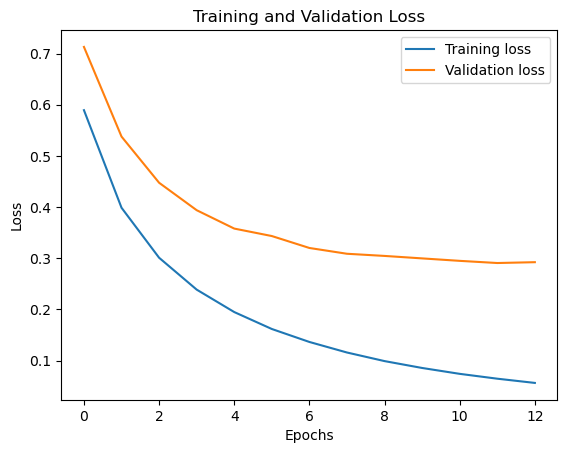

In [26]:
plt.plot(loss_tr, label='Training loss')
plt.plot(dev_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Compute accuracy, precision, recall and F1-Score:

In [24]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y_preds'])
            for x,y in zip(X_te,Y_te)]
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.8609566184649611
Precision: 0.8625498502990007
Recall: 0.8609438870308436
F1-Score: 0.8610637180562902


### Discuss how did you choose model hyperparameters ?

---

**Answer:**

I defined a unified function for hyperparameters tuning via grid-like search. These initial values were chosen based on typical practices, ensuring stability and a reasonable baseline performance. 

**Best hyperparameters are selected based on their performance on the validation set. 
The final hyperparameter values were then validated against a separate test set to confirm their generalizability.** This approach balances model complexity with performance, ensuring that the final model was both effective and efficient without overfitting. 

**Learning Rate:**
The choice depends on how quickly we want the model to converge and how fine-grained the updates should be. A higher learning rate might converge faster but can overshoot minima, while a smaller one converges more slowly but can achieve better fine-tuning. 

**Dropout Rate:**
The optimal value often depends on the complexity of the model and the amount of training data; more complex models or smaller datasets typically benefit from higher rates. If the model is overfitting (i.e., training accuracy is much higher than validation accuracy), increase the dropout rate.

**Embedding Size:**
Larger sizes can capture more detailed semantics but require more data and computational power. I start with the higher value (400) to capture more complex features in the data, then test with smaller sizes if the model is too slow or shows signs of overfitting.


The tuning function is defined as follows:

---

In [28]:
def tune_model(learning_rate_list, dropout_rate_list, hidden_dim_list, embedding_size_list,
               pretrained_embeddings=False, init_val=0.5, tolerance=0.001):

    accuracy_list, all_metrics_list, hyperparameters_list = [], [], []

    for hidden_dim in hidden_dim_list:
        for dim in embedding_size_list:
            for lr in learning_rate_list:
                for drop in dropout_rate_list:
                    W = network_weights(vocab_size=len(vocab),
                                        embedding_dim=dim,
                                        hidden_dim=hidden_dim,
                                        num_classes=3,
                                        init_val=init_val)

                    if pretrained_embeddings:
                        W[0] = w_glove  # Replace the weights of the embedding matrix with w_glove
                        freeze_emb = True
                    else:
                        freeze_emb = False

                    W, loss_tr, dev_loss = SGD(X_tr, Y_tr, W, X_dev=X_dev, Y_dev=Y_dev, lr=lr, dropout=drop, freeze_emb=freeze_emb, tolerance=tolerance, epochs=100, print_progress=False)
                    print(f"Training for dim {dim}, lr {lr}, dropout {drop}, hidden_dim {hidden_dim}")

                    # Evaluate the model on the validation set
                    preds_dev = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y_preds']) for x, y in zip(X_dev, Y_dev)]
                    accuracy = accuracy_score(Y_dev, preds_dev)
                    precision = precision_score(Y_dev, preds_dev, average='macro')
                    recall = recall_score(Y_dev, preds_dev, average='macro')
                    f_score = f1_score(Y_dev, preds_dev, average='macro')

                    print(f"\tAccuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f_score}")
                    
                    accuracy_list.append(accuracy)
                    all_metrics_list.append([accuracy, precision, recall, f_score])
                    hyper = [dim, lr, drop, hidden_dim, W]
                    hyperparameters_list.append(hyper)

    best_accuracy = max(accuracy_list)
    best_id = accuracy_list.index(best_accuracy)
    best_hyper = hyperparameters_list[best_id]
    W = best_hyper[4] # Get the best weights
    
    # Evaluate the model on the test set
    preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y_preds']) for x, y in zip(X_te, Y_te)]
    accuracy = accuracy_score(Y_te, preds_te)
    precision = precision_score(Y_te, preds_te, average='macro')
    recall = recall_score(Y_te, preds_te, average='macro')
    f_score = f1_score(Y_te, preds_te, average='macro')

    print("\nThe best parameters and scores on the test set:")
    print(f"Embedding dim: {best_hyper[0]}, LR: {best_hyper[1]}, Dropout rate: {best_hyper[2]}, Hidden dim: {best_hyper[3]}")
    print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f_score}")

In [327]:
# Tune the model with the following hyperparameters, more hyperparameters can be added
learning_rate_list = [0.05, 0.02, 0.01]
dropout_rate_list = [0.4, 0.3, 0.2]
embedding_size_list = [400, 300]
hidden_dim_list = [[]]

tune_model(learning_rate_list, dropout_rate_list, hidden_dim_list, embedding_size_list, pretrained_embeddings=False, init_val=0.5, tolerance=0.0001)

Training for dim 400, lr 0.05, dropout 0.4, hidden_dim []
	Accuracy: 0.8933333333333333, Precision: 0.8981339571401684, Recall: 0.8933333333333334, F1-Score: 0.894510582010582
Training for dim 400, lr 0.05, dropout 0.3, hidden_dim []
	Accuracy: 0.88, Precision: 0.886541889483066, Recall: 0.88, F1-Score: 0.8813593213424685
Training for dim 400, lr 0.05, dropout 0.2, hidden_dim []
	Accuracy: 0.8666666666666667, Precision: 0.8738060428849902, Recall: 0.8666666666666667, F1-Score: 0.8680573262261126
Training for dim 400, lr 0.02, dropout 0.4, hidden_dim []
	Accuracy: 0.8666666666666667, Precision: 0.8801054018445322, Recall: 0.8666666666666667, F1-Score: 0.8693584784010316
Training for dim 400, lr 0.02, dropout 0.3, hidden_dim []
	Accuracy: 0.8933333333333333, Precision: 0.8981339571401684, Recall: 0.8933333333333334, F1-Score: 0.894510582010582
Training for dim 400, lr 0.02, dropout 0.2, hidden_dim []
	Accuracy: 0.88, Precision: 0.8863000755857898, Recall: 0.88, F1-Score: 0.88135308731137

| Training Configuration       | Accuracy | Precision | Recall  | F1-Score |
|------------------------------|----------|-----------|---------|----------|
| dim 400, lr 0.05, dropout 0.4| 0.8933   | 0.8981    | 0.8933  | 0.8945   |
| dim 400, lr 0.05, dropout 0.3| 0.88     | 0.8865    | 0.88    | 0.8814   |
| dim 400, lr 0.05, dropout 0.2| 0.8667   | 0.8738    | 0.8667  | 0.8681   |
| dim 400, lr 0.02, dropout 0.4| 0.8667   | 0.8801    | 0.8667  | 0.8694   |
| dim 400, lr 0.02, dropout 0.3| 0.8933   | 0.8981    | 0.8933  | 0.8945   |
| dim 400, lr 0.02, dropout 0.2| 0.88     | 0.8863    | 0.88    | 0.8814   |
| dim 400, lr 0.01, dropout 0.4| 0.8933   | 0.8995    | 0.8933  | 0.8948   |
| dim 400, lr 0.01, dropout 0.3| 0.88     | 0.8835    | 0.88    | 0.8807   |
| dim 400, lr 0.01, dropout 0.2| 0.9      | 0.9038    | 0.9     | 0.9007   |
| dim 300, lr 0.05, dropout 0.4| 0.9      | 0.9026    | 0.9     | 0.9007   |
| dim 300, lr 0.05, dropout 0.3| 0.88     | 0.8887    | 0.88    | 0.8814   |
| dim 300, lr 0.05, dropout 0.2| 0.88     | 0.8834    | 0.88    | 0.8802   |
| dim 300, lr 0.02, dropout 0.4| 0.86     | 0.8661    | 0.86    | 0.8613   |
| dim 300, lr 0.02, dropout 0.3| 0.8533   | 0.8591    | 0.8533  | 0.8548   |
| dim 300, lr 0.02, dropout 0.2| 0.8933   | 0.8981    | 0.8933  | 0.8945   |
| dim 300, lr 0.01, dropout 0.4| 0.9      | 0.9032    | 0.9     | 0.9008   |
| dim 300, lr 0.01, dropout 0.3| 0.8933   | 0.8978    | 0.8933  | 0.8943   |
| dim 300, lr 0.01, dropout 0.2| 0.88     | 0.8877    | 0.88    | 0.8817   |

**Test Set Best Parameters and Scores:** 


| Embedding dim | LR  | Dropout rate | Hidden dim | Accuracy | Precision | Recall  | F1-Score |
|---------------|-----|--------------|------------|----------|-----------|---------|----------|
| 400           | 0.01| 0.2          | []         | 0.8632   | 0.8645    | 0.8632  | 0.8628   |

Given that the validation set accuracy is around 88% and the test set accuracy is around 86%, the small difference between these two percentages suggests that the model generalizes well to new, unseen data 

# Use Pre-trained Embeddings

Now re-train the network using GloVe pre-trained embeddings. You need to modify the `backward_pass` function above to stop computing gradients and updating weights of the embedding matrix.

Use the function below to obtain the embedding martix for your vocabulary. Generally, that should work without any problem. If you get errors, you can modify it.

In [30]:
def get_glove_embeddings(f_zip, f_txt, word2id, emb_size=300):
    w_emb = np.zeros((len(word2id), emb_size))
    with zipfile.ZipFile(f_zip) as z:
        with z.open(f_txt) as f:
            for line in f:
                line = line.decode('utf-8')
                word = line.split()[0]

                if word in vocab:
                    emb = np.array(line.strip('\n').split()[1:]).astype(np.float32)
                    w_emb[word2id[word]] +=emb
    return w_emb

In [31]:
w_glove = get_glove_embeddings("glove.840B.300d.zip","glove.840B.300d.txt",word2id)

First, initialise the weights of your network using the `network_weights` function. Second, replace the weigths of the embedding matrix with `w_glove`. Finally, train the network by freezing the embedding weights:

In [322]:
# Initialise the weights of your network
W = network_weights(vocab_size=len(vocab), embedding_dim=300, hidden_dim=[], num_classes=3, init_val = 0.1)

#Replace the weigths of the embedding matrix with w_glove
W[0] = w_glove

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)


Shape W0 (2144, 300)
Shape W1 (300, 3)


In [279]:
W, loss_tr, dev_loss = SGD(X_tr,Y_tr,W,X_dev=X_dev, Y_dev=Y_dev,lr=0.01,
                                       dropout=0.3, freeze_emb=True, tolerance=0.000001,epochs=100)

Epoch: 1 | Training loss: 0.5776114959531579 | Validation loss: 0.5905857577650572
Epoch: 2 | Training loss: 0.4565494696675726 | Validation loss: 0.44488920470716475
Epoch: 3 | Training loss: 0.4067433164107791 | Validation loss: 0.3770692515882212
Epoch: 4 | Training loss: 0.3830656688438014 | Validation loss: 0.33623488670874735
Epoch: 5 | Training loss: 0.36649182842496714 | Validation loss: 0.31379779245049977
Epoch: 6 | Training loss: 0.3556050867924254 | Validation loss: 0.29742613168136084
Epoch: 7 | Training loss: 0.35658614471214006 | Validation loss: 0.2893815761620691
Epoch: 8 | Training loss: 0.3473018973106432 | Validation loss: 0.2756609260948226
Epoch: 9 | Training loss: 0.3427618133091941 | Validation loss: 0.26510613043211745
Epoch: 10 | Training loss: 0.33880682191790346 | Validation loss: 0.26465076744185434
Epoch: 11 | Training loss: 0.3379151075523934 | Validation loss: 0.2606298878051885
Epoch: 12 | Training loss: 0.33372939084328973 | Validation loss: 0.25456519

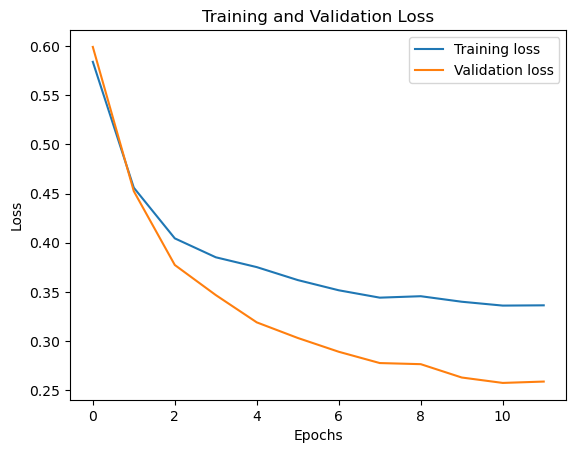

In [324]:
plt.plot(loss_tr, label='Training loss')
plt.plot(dev_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [280]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y_preds'])
            for x,y in zip(X_te,Y_te)]

print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))


Accuracy: 0.8843159065628476
Precision: 0.8853236274860069
Recall: 0.8842920847268673
F1-Score: 0.8845749228653209


### Discuss how did you choose model hyperparameters ?

---

Answer:

I performed a grid-search below using the same unified tuning function as described above, with different combinations of hyperparameters.

'pretrained_embeddings' is set to True, so the tunning function uses pre-trained glove embeddings and does not update weight of the embedding layer.

---


### Do you get better performance with pre-trained embeddings?
---
Answer:

Yes, this pre-existing knowledge helps the model to better understand the context and nuances of different words, reducing training time and improving the model's ability to generalize to new, unseen data.

---

In [328]:
# Hyperparameter tuning with pretrained embeddings, more hyperparameters can be added

learning_rate_list = [0.1, 0.05, 0.01, 0.001]
dropout_rate_list = [0.4, 0.3, 0.2]
embedding_size_list = [300]
hidden_dim_list = [[]]

tune_model(learning_rate_list, dropout_rate_list, hidden_dim_list, embedding_size_list, pretrained_embeddings=True, init_val=0.5, tolerance=0.000001)

Training for dim 300, lr 0.1, dropout 0.4, hidden_dim []
	Accuracy: 0.92, Precision: 0.9235621521335807, Recall: 0.9199999999999999, F1-Score: 0.9205026455026456
Training for dim 300, lr 0.1, dropout 0.3, hidden_dim []
	Accuracy: 0.8933333333333333, Precision: 0.9002331002331002, Recall: 0.8933333333333332, F1-Score: 0.89423812535767
Training for dim 300, lr 0.1, dropout 0.2, hidden_dim []
	Accuracy: 0.9266666666666666, Precision: 0.9355663169222491, Recall: 0.9266666666666666, F1-Score: 0.9267619688441388
Training for dim 300, lr 0.05, dropout 0.4, hidden_dim []
	Accuracy: 0.9066666666666666, Precision: 0.9122257053291536, Recall: 0.9066666666666666, F1-Score: 0.9065148518036056
Training for dim 300, lr 0.05, dropout 0.3, hidden_dim []
	Accuracy: 0.9266666666666666, Precision: 0.9306418219461698, Recall: 0.9266666666666666, F1-Score: 0.9270285158088392
Training for dim 300, lr 0.05, dropout 0.2, hidden_dim []
	Accuracy: 0.9066666666666666, Precision: 0.9174603174603174, Recall: 0.9066

| Training Configuration       | Accuracy | Precision | Recall  | F1-Score |
|------------------------------|----------|-----------|---------|----------|
| dim 300, lr 0.1, dropout 0.4 | 0.92     | 0.9236    | 0.92    | 0.9205   |
| dim 300, lr 0.1, dropout 0.3 | 0.8933   | 0.9002    | 0.8933  | 0.8942   |
| dim 300, lr 0.1, dropout 0.2 | 0.9267   | 0.9356    | 0.9267  | 0.9268   |
| dim 300, lr 0.05, dropout 0.4| 0.9067   | 0.9122    | 0.9067  | 0.9065   |
| dim 300, lr 0.05, dropout 0.3| 0.9267   | 0.9306    | 0.9267  | 0.9270   |
| dim 300, lr 0.05, dropout 0.2| 0.9067   | 0.9175    | 0.9067  | 0.9073   |
| dim 300, lr 0.01, dropout 0.4| 0.92     | 0.9240    | 0.92    | 0.9204   |
| dim 300, lr 0.01, dropout 0.3| 0.9133   | 0.9198    | 0.9133  | 0.9136   |
| dim 300, lr 0.01, dropout 0.2| 0.9267   | 0.9306    | 0.9267  | 0.9270   |
| dim 300, lr 0.001, dropout 0.4| 0.9133  | 0.9168    | 0.9133  | 0.9140   |
| dim 300, lr 0.001, dropout 0.3| 0.9067  | 0.9135    | 0.9067  | 0.9068   |
| dim 300, lr 0.001, dropout 0.2| 0.9     | 0.9038    | 0.9     | 0.9008   |

**Test Set Best Parameters and Scores:**

| Embedding dim | LR  | Dropout rate | Hidden dim | Accuracy | Precision | Recall  | F1-Score |
|---------------|-----|--------------|------------|----------|-----------|---------|----------|
| 300           | 0.1 | 0.2          | []         | 0.8821   | 0.8836    | 0.8820  | 0.8809   |


The small difference between performances of dev and test dataset suggests that the model generalizes well to new, unseen data.

# Extend to support deeper architectures

Extend the network to support back-propagation for more hidden layers. You need to modify the `backward_pass` function above to compute gradients and update the weights between intermediate hidden layers. Finally, train and evaluate a network with a deeper architecture. Do deeper architectures increase performance?

In [269]:
W = network_weights(vocab_size=len(vocab),embedding_dim=300,hidden_dim=[30],num_classes=3, init_val=0.1)
W[0] = w_glove
for i in range(len(W)):
    print('Shape of W'+str(i), W[i].shape)

W, loss_tr, dev_loss = SGD(X_tr,Y_tr,W,X_dev=X_dev, Y_dev=Y_dev,lr=0.002,dropout=0.2,freeze_emb=True,print_progress=True,
tolerance=0.0000001,epochs=100)

Shape of W0 (2144, 300)
Shape of W1 (300, 30)
Shape of W2 (30, 3)


Epoch: 1 | Training loss: 1.0798683461132956 | Validation loss: 1.0799592058168337
Epoch: 2 | Training loss: 1.036888125485237 | Validation loss: 1.0417795878213367
Epoch: 3 | Training loss: 0.9463180073392995 | Validation loss: 0.9622737659155647
Epoch: 4 | Training loss: 0.7993618045904655 | Validation loss: 0.8264803435258168
Epoch: 5 | Training loss: 0.6273618678986401 | Validation loss: 0.6545934925449486
Epoch: 6 | Training loss: 0.505755307855396 | Validation loss: 0.5109818593056401
Epoch: 7 | Training loss: 0.4267304376964543 | Validation loss: 0.4129780135041659
Epoch: 8 | Training loss: 0.39003671359677816 | Validation loss: 0.36346307538857864
Epoch: 9 | Training loss: 0.36443063679574017 | Validation loss: 0.3276964500025228
Epoch: 10 | Training loss: 0.3498338973181644 | Validation loss: 0.2883359433155288
Epoch: 11 | Training loss: 0.34343531966707375 | Validation loss: 0.2729785702326714
Epoch: 12 | Training loss: 0.3629753859867414 | Validation loss: 0.281902424474885


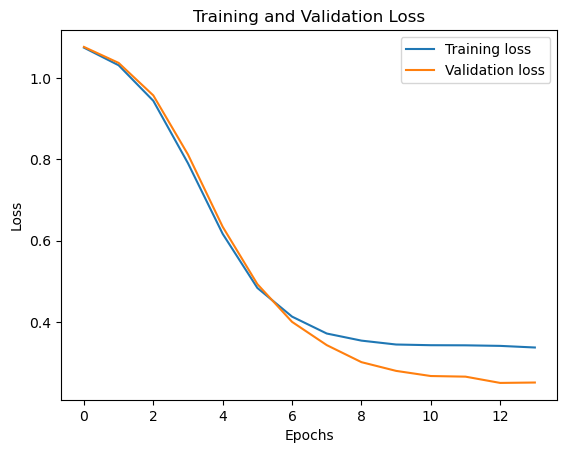

In [326]:
plt.plot(loss_tr, label='Training loss')
plt.plot(dev_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [270]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y_preds'])
            for x,y in zip(X_te,Y_te)]

print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.8887652947719689
Precision: 0.8887219253686043
Recall: 0.8886733556298774
F1-Score: 0.8876438407847577


### Discuss how did you choose model hyperparameters ?

---

Answer:

Similar as before, I performed a grid-search using the same unified tuning function as described above, with different combinations of hyperparameters. The following hidden dimensions are for demonstration purposes; more hidden dimensions are tested outside of this notebook.

'pretrained_embeddings' is set to True as below, so the tunning function uses pre-trained glove embeddings and does not update weight of the embedding layer.

---


### Do deeper architectures increase performance?
---
Answer:

Not always. Deeper architectures can potentially improve performance by capturing complex data patterns. However, deeper architectures often lead to marginal improvements and increase the risk of overfitting, particularly with limited data. These models also require extensive hyperparameter tuning, making them resource-intensive.

---

In [273]:
# Tune the model with the following hyperparameters, more hyperparameters can be added
learning_rate_list = [0.002, 0.01, 0.1]
dropout_rate_list = [0.2, 0.4]
embedding_size_list = [300]
hidden_dim_list = [[30],[90],[100,30]]

tune_model(learning_rate_list, dropout_rate_list, hidden_dim_list, embedding_size_list, pretrained_embeddings=True, init_val=0.1, tolerance=0.0000001)

Training for dim 300, lr 0.002, dropout 0.2, hidden_dim [30]
	Accuracy: 0.9133333333333333, Precision: 0.9183829138062548, Recall: 0.9133333333333332, F1-Score: 0.9137561422102322
Training for dim 300, lr 0.002, dropout 0.4, hidden_dim [30]
	Accuracy: 0.92, Precision: 0.9251461988304094, Recall: 0.9199999999999999, F1-Score: 0.9203328749109086
Training for dim 300, lr 0.01, dropout 0.2, hidden_dim [30]
	Accuracy: 0.9, Precision: 0.9106060606060605, Recall: 0.9, F1-Score: 0.901133677197507
Training for dim 300, lr 0.01, dropout 0.4, hidden_dim [30]
	Accuracy: 0.9133333333333333, Precision: 0.9165125169564682, Recall: 0.9133333333333334, F1-Score: 0.9140806070898352
Training for dim 300, lr 0.1, dropout 0.2, hidden_dim [30]
	Accuracy: 0.8466666666666667, Precision: 0.8949771689497718, Recall: 0.8466666666666667, F1-Score: 0.8455911873933554
Training for dim 300, lr 0.1, dropout 0.4, hidden_dim [30]
	Accuracy: 0.88, Precision: 0.8909479686386316, Recall: 0.88, F1-Score: 0.8803157996706384

| Training Configuration           | Accuracy | Precision | Recall  | F1-Score |
|----------------------------------|----------|-----------|---------|----------|
| dim 300, lr 0.002, dropout 0.2, hidden_dim [30] | 0.9133   | 0.9184    | 0.9133  | 0.9138   |
| dim 300, lr 0.002, dropout 0.4, hidden_dim [30] | 0.92     | 0.9251    | 0.92    | 0.9203   |
| dim 300, lr 0.01, dropout 0.2, hidden_dim [30]  | 0.9      | 0.9106    | 0.9     | 0.9011   |
| dim 300, lr 0.01, dropout 0.4, hidden_dim [30]  | 0.9133   | 0.9165    | 0.9133  | 0.9141   |
| dim 300, lr 0.1, dropout 0.2, hidden_dim [30]   | 0.8467   | 0.8950    | 0.8467  | 0.8456   |
| dim 300, lr 0.1, dropout 0.4, hidden_dim [30]   | 0.88     | 0.8909    | 0.88    | 0.8803   |
| dim 300, lr 0.002, dropout 0.2, hidden_dim [90] | 0.9133   | 0.9174    | 0.9133  | 0.9138   |
| dim 300, lr 0.002, dropout 0.4, hidden_dim [90] | 0.92     | 0.9251    | 0.92    | 0.9203   |
| dim 300, lr 0.01, dropout 0.2, hidden_dim [90]  | 0.9133   | 0.9190    | 0.9133  | 0.9140   |
| dim 300, lr 0.01, dropout 0.4, hidden_dim [90]  | 0.92     | 0.9240    | 0.92    | 0.9204   |
| dim 300, lr 0.1, dropout 0.2, hidden_dim [90]   | 0.9133   | 0.9279    | 0.9133  | 0.9122   |
| dim 300, lr 0.1, dropout 0.4, hidden_dim [90]   | 0.8867   | 0.9154    | 0.8867  | 0.8879   |
| dim 300, lr 0.002, dropout 0.2, hidden_dim [100, 30] | 0.9   | 0.9076    | 0.9     | 0.9003   |
| dim 300, lr 0.002, dropout 0.4, hidden_dim [100, 30] | 0.7333 | 0.7579    | 0.7333  | 0.6930   |
| dim 300, lr 0.01, dropout 0.2, hidden_dim [100, 30]  | 0.9067 | 0.9146    | 0.9067  | 0.9068   |
| dim 300, lr 0.01, dropout 0.4, hidden_dim [100, 30]  | 0.9067 | 0.9175    | 0.9067  | 0.9073   |
| dim 300, lr 0.1, dropout 0.2, hidden_dim [100, 30]   | 0.9    | 0.9067    | 0.9     | 0.9014   |
| dim 300, lr 0.1, dropout 0.4, hidden_dim [100, 30]   | 0.88   | 0.8943    | 0.88    | 0.8737   |

**Test Set Best Parameters and Scores:**

| Embedding dim | LR    | Dropout rate | Hidden dim   | Accuracy | Precision | Recall  | F1-Score |
|---------------|-------|--------------|--------------|----------|-----------|---------|----------|
| 300           | 0.002 | 0.4          | [30]         | 0.8832   | 0.8828    | 0.8831  | 0.8828   |

The small difference between performances of dev and test dataset suggests that the model generalizes well to new, unseen data.


## Full Results

Add your final results here: ***Note that the numbers are from the first run of each setting, NOT from the tunning phase**

| Model | Precision  | Recall  | F1-Score  | Accuracy
|:-:|:-:|:-:|:-:|:-:|
| Average Embedding (400, 0.01, 0.2)  | 0.8625  |0.8609  | 0.8610  | 0.8609  |
| Average Embedding (Pre-trained) (300, 0.01, 0.3)  | 0.8853  | 0.8842  | 0.8845  | 0.8843  |
| Average Embedding (Pre-trained) + X hidden layers (300, 0.02, 0.2 [30])   | 0.8887  | 0.8886  | 0.8876  | 0.8887  |


Please discuss why your best performing model is better than the rest and provide a bried error analaysis.

### Why your best performing model is better than the rest?

---
**Answer:**

The best performing model combines a deep architecture with pre-trained embeddings, outperforming simpler configurations due to several key advantages:

- **Complex Pattern Learning**: The deep architecture enhances the model's ability to capture complex interactions and non-linear relationships in the data.
- **Rich Semantic Understanding**: Pre-trained embeddings provide a rich, semantic foundation, embedding prior linguistic knowledge that aids in understanding context and nuances beyond the training data.
- **Synergistic Effect**: This combination could improve performance by leveraging both the intricate structure and the extensive contextual knowledge encoded in pre-trained embeddings.

---

### Provide a bried error analaysis

I defined a function to print out the errors of each type and count occurrences. Please see in the code block below:

In [319]:
# Error analysis
labels = ["Politics", "Sports", "Economy"]
misclassifications = []
error_details = {}

for i, (text, actual, predicted) in enumerate(zip(test_data['text'], Y_te, preds_te)):
    if actual != predicted:
        misclassifications.append((i, text, labels[actual], labels[predicted]))
        error_key = f"{labels[actual]} misclassified as {labels[predicted]}"
        
        # Initialize or update the dictionary for each error type
        if error_key not in error_details:
            error_details[error_key] = {'count': 1, 'examples': [(i, text)]}
        else:
            error_details[error_key]['count'] += 1
            if len(error_details[error_key]['examples']) < 2:
                error_details[error_key]['examples'].append((i, text))

# Print error counts and examples:
for error_type, details in error_details.items():
    print(f"\n{error_type}: {details['count']}")
    for example in details['examples']:
        print(f"\t{example[1]}")


Politics misclassified as Economy: 19
	AP - The man who claims Gov. James E. McGreevey sexually harassed him was pushing for a cash settlement of up to  #36;50 million before the governor decided to announce that he was gay and had an extramarital affair, sources told The Associated Press.
	AFP - India's Tata Iron and Steel Company Ltd. took a strategic step to expand its Asian footprint with the announcement it will buy the Asia-Pacific steel operations of Singapore's NatSteel Ltd.

Politics misclassified as Sports: 22
	SANTA MARIA, Calif. - Fans of Michael Jackson erupted in cheers Monday as the pop star emerged from a double-decker tour bus and went into court for a showdown with the prosecutor who has pursued him for years on child molestation charges...
	Richard Faulds and Stephen Parry are going for gold for Great Britain on day four in Athens.

Sports misclassified as Politics: 18
	AP - The Charlotte Bobcats traded center Predrag Drobnjak to the Atlanta Hawks on Monday for a se

**Error Analaysis:**

Politics misclassified as Economy (19 examples):
- Reason for Misclassification: The frequent mention of monetary figures and economic terms (e.g., "cash settlement," "buy operations") in a political context might confuse the model into categorizing them as economic news.

Politics misclassified as Sports (22 examples):
- Reason for Misclassification: The dynamic and competitive nature of the events described, along with the presence of crowds and public figures, might resemble sports coverage, leading to incorrect classification.

Sports misclassified as Politics (18 examples):
- Reason for Misclassification: The inclusion of formal language and reference to geopolitical activities often associated with politics might lead to these articles being misclassified.

Sports misclassified as Economy (7 examples):
- Reason for Misclassification: The emphasis on numbers and financial implications (e.g., record achievements, betting odds) can mirror the focus typically found in economic reporting.

Economy misclassified as Politics (35 examples):
- Reason for Misclassification: The close interplay between economic policies and political decisions may lead to confusion, especially if the economic news heavily involves governmental action.

Economy misclassified as Sports (3 examples):
- Reason for Misclassification: The use of action-oriented or competitive phrases in economic contexts, such as describing market movements or corporate strategies in sports-like terms.

**Recommendations for Improvement:**

Since GloVe embeddings are not context-aware, consider integrating context-aware embeddings which better capture semantic nuances and contextual differences in word usage. Additionally, enhancing feature engineering to distinguish the contextual usage of ambiguous terms and expanding the training dataset with diverse examples could help the model differentiate subtle linguistic cues across categories. 

---